<a href="https://colab.research.google.com/github/aaronmat1905/hierarchical-instrument-classification/blob/main/InstrumentRecog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q librosa

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import os
import pickle
import json
import time
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style("whitegrid")

In [64]:
# Path configuration - UPDATE THESE PATHS AS NEEDED
DATA_PATH = "/content/drive/MyDrive/ML_Project/IRMAS-TrainingData"
PROJECT_PATH = "/content/drive/MyDrive/IRMAS_Project"
MODELS_PATH = f"{PROJECT_PATH}/models"
RESULTS_PATH = f"{PROJECT_PATH}/results"
VIZ_PATH = f"{PROJECT_PATH}/visualizations"

# **EDA**

In [66]:
def create_project_folders():
    """Create necessary folder structure for the project"""
    folders = [MODELS_PATH, RESULTS_PATH, VIZ_PATH]
    for folder in folders:
        os.makedirs(folder, exist_ok=True)
    print("✓ Project folders created")
create_project_folders()

✓ Project folders created


In [67]:
def get_instrument_list(data_path):
    """Get list of valid instrument directories"""
    all_items = os.listdir(data_path)
    instruments = []

    for item in all_items:
        item_path = os.path.join(data_path, item)
        # Only include directories with .wav files
        if os.path.isdir(item_path):
            wav_files = [f for f in os.listdir(item_path) if f.endswith('.wav')]
            if len(wav_files) > 0:
                instruments.append(item)

    return sorted(instruments)
# Get instruments
instruments = get_instrument_list(DATA_PATH)
print(f"Total instruments: {len(instruments)}")
print(f"Instruments: {instruments}\n")

Total instruments: 11
Instruments: ['cel', 'cla', 'flu', 'gac', 'gel', 'org', 'pia', 'sax', 'tru', 'vio', 'voi']



In [68]:
# Count samples per instrument
def analyze_dataset(data_path, instruments):
    """Analyze dataset composition"""
    data_info = []
    for instrument in instruments:
        instrument_path = os.path.join(data_path, instrument)
        num_samples = len([f for f in os.listdir(instrument_path) if f.endswith('.wav')])
        data_info.append({'Instrument': instrument, 'Num_Samples': num_samples})

    df_info = pd.DataFrame(data_info)
    print(df_info.to_string(index=False))
    print(f"\nTotal training samples: {df_info['Num_Samples'].sum()}")
    print(f"\nClass balance statistics:")
    print(df_info['Num_Samples'].describe())

    return df_info

df_data_info = analyze_dataset(DATA_PATH, instruments)

Instrument  Num_Samples
       cel          388
       cla          505
       flu          451
       gac          637
       gel          760
       org          682
       pia          721
       sax          626
       tru          577
       vio          580
       voi          778

Total training samples: 6705

Class balance statistics:
count     11.000000
mean     609.545455
std      125.216104
min      388.000000
25%      541.000000
50%      626.000000
75%      701.500000
max      778.000000
Name: Num_Samples, dtype: float64


# Audio Visualization

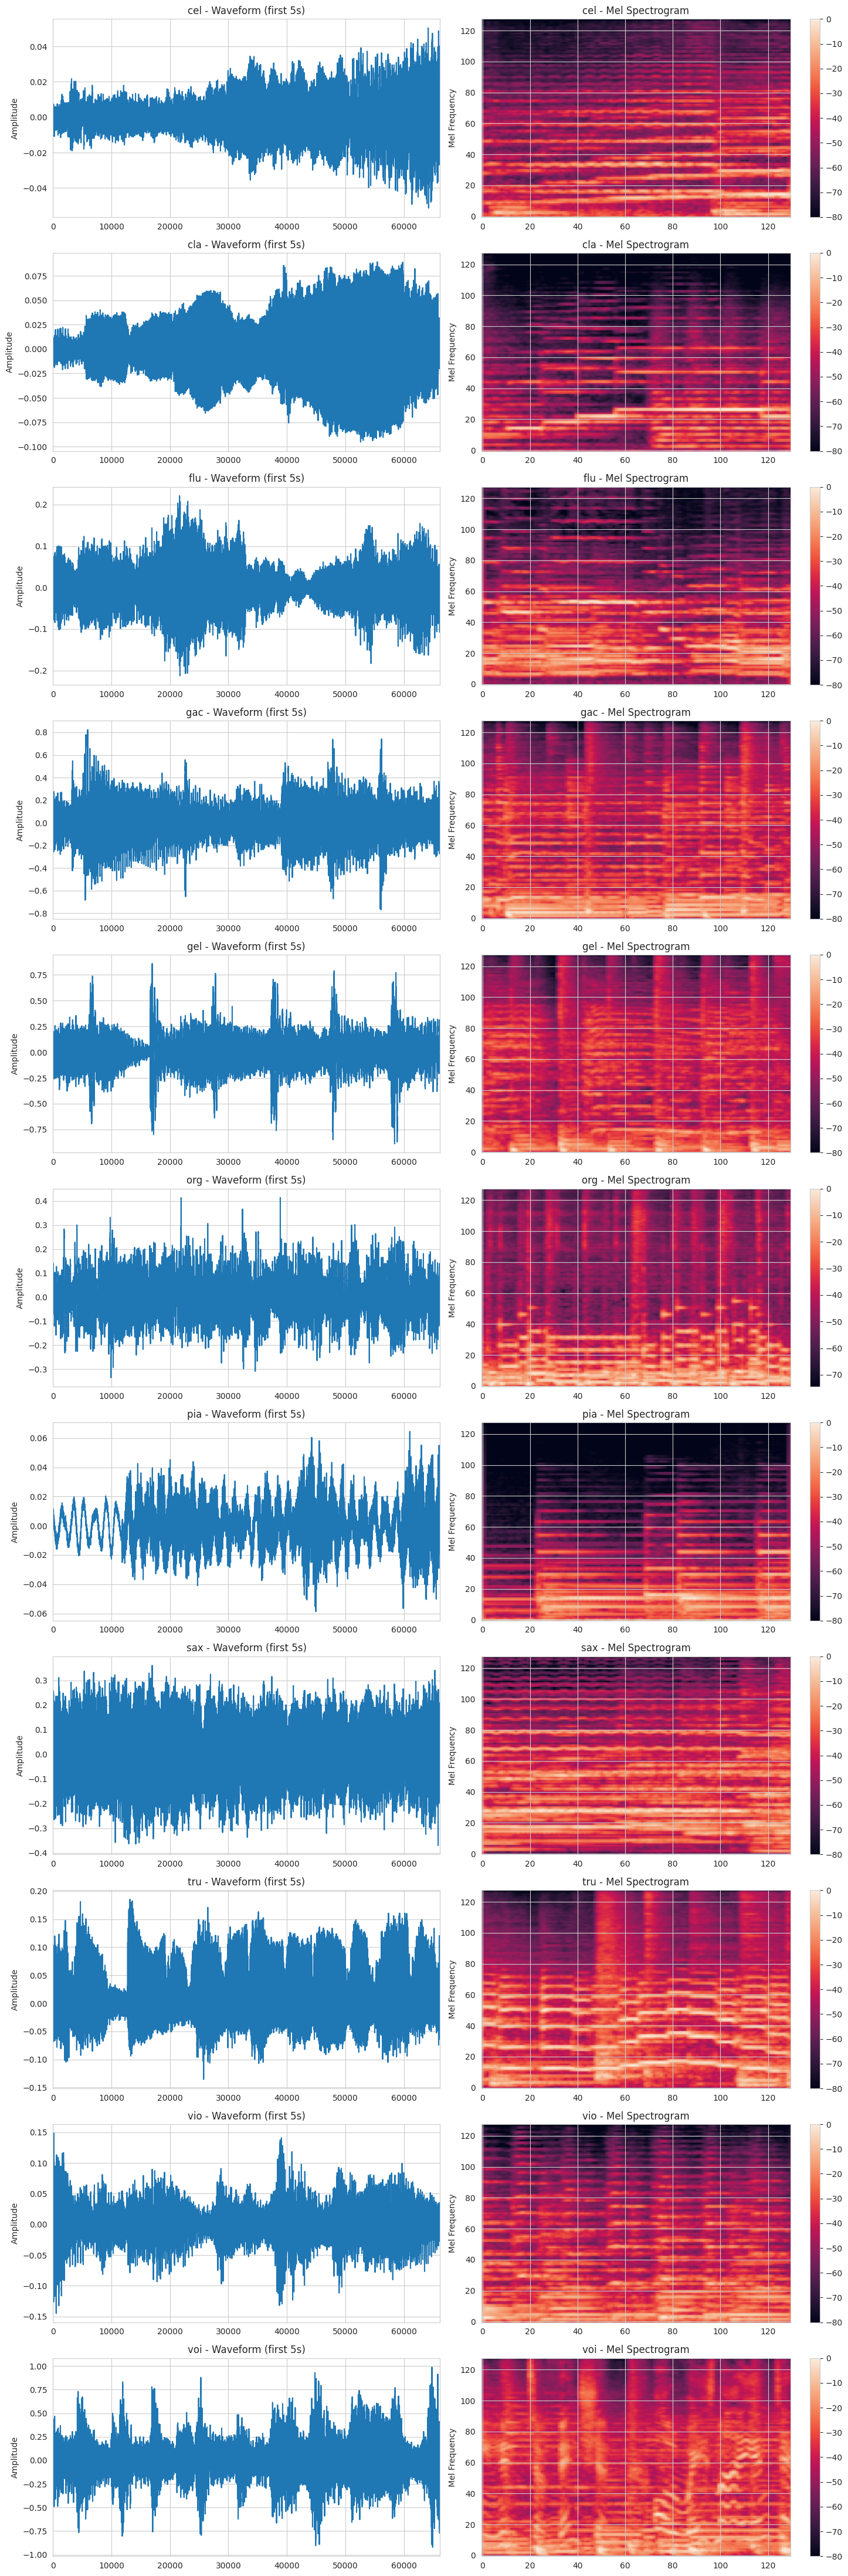

✓ Audio samples visualized and saved


In [69]:
def visualize_audio_samples(data_path, instruments, save_path):
    """Visualize waveforms and spectrograms for each instrument"""
    fig, axes = plt.subplots(len(instruments), 2, figsize=(15, 4*len(instruments)))

    for idx, instrument in enumerate(instruments):
        instrument_path = os.path.join(data_path, instrument)
        wav_files = [f for f in os.listdir(instrument_path) if f.endswith('.wav')]
        sample_file = os.path.join(instrument_path, wav_files[0])

        try:
            # Load audio
            y, sr = librosa.load(sample_file)

            # Plot waveform (first 5 seconds)
            time_limit = min(sr * 5, len(y))
            axes[idx, 0].plot(y[:time_limit])
            axes[idx, 0].set_title(f'{instrument} - Waveform (first 5s)')
            axes[idx, 0].set_ylabel('Amplitude')
            axes[idx, 0].set_xlim([0, time_limit])

            # Plot Mel Spectrogram
            S = librosa.feature.melspectrogram(y=y, sr=sr)
            S_db = librosa.power_to_db(S, ref=np.max)
            img = axes[idx, 1].imshow(S_db, aspect='auto', origin='lower')
            axes[idx, 1].set_title(f'{instrument} - Mel Spectrogram')
            axes[idx, 1].set_ylabel('Mel Frequency')
            plt.colorbar(img, ax=axes[idx, 1])

        except Exception as e:
            print(f"Error processing {instrument}: {e}")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ Audio samples visualized and saved")

visualize_audio_samples(DATA_PATH, instruments, f"{VIZ_PATH}/01_audio_samples.png")

In [70]:
# Audio Characteristics Analysis
def analyze_audio_characteristics(data_path, instruments, sample_size=10):
    """Analyze duration characteristics of audio files"""
    characteristics = []

    for instrument in instruments:
        instrument_path = os.path.join(data_path, instrument)
        files = [f for f in os.listdir(instrument_path) if f.endswith('.wav')]
        durations = []

        for file in files[:sample_size]:
            try:
                y, sr = librosa.load(os.path.join(instrument_path, file))
                duration = len(y) / sr
                durations.append(duration)
            except Exception as e:
                print(f"Error loading {instrument}/{file}: {e}")

        if durations:
            characteristics.append({
                'Instrument': instrument,
                'Avg_Duration_s': np.mean(durations),
                'Min_Duration_s': np.min(durations),
                'Max_Duration_s': np.max(durations)
            })

    df_char = pd.DataFrame(characteristics)
    print(df_char.to_string(index=False))
    df_char.to_csv(f"{RESULTS_PATH}/audio_characteristics.csv", index=False)
    print("\n✓ Audio characteristics saved")

    return df_char

df_characteristics = analyze_audio_characteristics(DATA_PATH, instruments)

Instrument  Avg_Duration_s  Min_Duration_s  Max_Duration_s
       cel             3.0             3.0             3.0
       cla             3.0             3.0             3.0
       flu             3.0             3.0             3.0
       gac             3.0             3.0             3.0
       gel             3.0             3.0             3.0
       org             3.0             3.0             3.0
       pia             3.0             3.0             3.0
       sax             3.0             3.0             3.0
       tru             3.0             3.0             3.0
       vio             3.0             3.0             3.0
       voi             3.0             3.0             3.0

✓ Audio characteristics saved


# **Feature Engineering**

In [71]:
def extract_audio_features(audio_path, sr=22050):
    """
    Extract comprehensive audio features from a single file.
    Returns a 51-dimensional feature vector.

    Features extracted:
    - MFCC (13 mean + 13 std) = 26 features
    - Spectral Centroid (mean + std) = 2 features
    - Spectral Rolloff (mean + std) = 2 features
    - Zero Crossing Rate (mean + std) = 2 features
    - Spectral Contrast (7 means) = 7 features
    - Chroma (12 means) = 12 features
    Total: 51 features
    """
    try:
        # Load audio
        y, sr = librosa.load(audio_path, sr=sr)

        # MFCC Features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfcc, axis=1)
        mfcc_std = np.std(mfcc, axis=1)

        # Spectral Features
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spec_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spec_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

        # Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(y)[0]

        # Chroma Features
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma, axis=1)

        # Combine all features
        features = np.concatenate([
            mfcc_mean,                                      # 13
            mfcc_std,                                       # 13
            [np.mean(spec_centroid), np.std(spec_centroid)],  # 2
            [np.mean(spec_rolloff), np.std(spec_rolloff)],    # 2
            [np.mean(zcr), np.std(zcr)],                     # 2
            np.mean(spec_contrast, axis=1),                  # 7
            chroma_mean                                      # 12
        ])

        return features

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# Test feature extraction
test_file = os.path.join(DATA_PATH, instruments[0],
                         os.listdir(os.path.join(DATA_PATH, instruments[0]))[0])
test_features = extract_audio_features(test_file)
print(f"\n✓ Feature extraction test successful")
print(f"Feature vector shape: {test_features.shape}")
print(f"Number of features: {len(test_features)}")


✓ Feature extraction test successful
Feature vector shape: (51,)
Number of features: 51


In [72]:
# Extract Features for all data
def extract_all_features(data_path, instruments):
    """Extract features for all audio files"""
    X_full = []
    y_full = []
    file_paths = []

    total_files = sum([len([f for f in os.listdir(os.path.join(data_path, inst))
                           if f.endswith('.wav')]) for inst in instruments])
    processed = 0

    print(f"Extracting features from {total_files} files...")

    for instrument in instruments:
        instrument_path = os.path.join(data_path, instrument)
        files = [f for f in os.listdir(instrument_path) if f.endswith('.wav')]

        for file in files:
            file_path = os.path.join(instrument_path, file)
            features = extract_audio_features(file_path)

            if features is not None:
                X_full.append(features)
                y_full.append(instrument)
                file_paths.append(file_path)

            processed += 1
            if processed % 500 == 0:
                print(f"  Processed {processed}/{total_files} files...")

    X_full = np.array(X_full)
    y_full = np.array(y_full)

    print(f"\n✓ Feature extraction complete")
    print(f"X_full shape: {X_full.shape}")
    print(f"y_full shape: {y_full.shape}")

    return X_full, y_full, file_paths

X_full, y_full, file_paths = extract_all_features(DATA_PATH, instruments)

Extracting features from 6705 files...
  Processed 500/6705 files...
  Processed 1000/6705 files...
  Processed 1500/6705 files...
  Processed 2000/6705 files...
  Processed 2500/6705 files...
  Processed 3000/6705 files...
  Processed 3500/6705 files...
  Processed 4000/6705 files...
  Processed 4500/6705 files...
  Processed 5000/6705 files...
  Processed 5500/6705 files...
  Processed 6000/6705 files...
  Processed 6500/6705 files...

✓ Feature extraction complete
X_full shape: (6705, 51)
y_full shape: (6705,)


In [73]:
# Train-test-split
def split_and_save_data(X, y, test_size=0.2, random_state=42):
    """Split data into train and test sets with stratification"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    print(f"✓ Data split complete")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"\nTraining set distribution:")
    print(pd.Series(y_train).value_counts().sort_index())
    print(f"\nTest set distribution:")
    print(pd.Series(y_test).value_counts().sort_index())

    # Save datasets
    np.save(f"{PROJECT_PATH}/X_train.npy", X_train)
    np.save(f"{PROJECT_PATH}/X_test.npy", X_test)
    np.save(f"{PROJECT_PATH}/y_train.npy", y_train)
    np.save(f"{PROJECT_PATH}/y_test.npy", y_test)
    print("\n✓ Data saved to disk")

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_and_save_data(X_full, y_full)

✓ Data split complete
X_train shape: (5364, 51)
X_test shape: (1341, 51)

Training set distribution:
cel    310
cla    404
flu    361
gac    510
gel    608
org    546
pia    577
sax    501
tru    461
vio    464
voi    622
Name: count, dtype: int64

Test set distribution:
cel     78
cla    101
flu     90
gac    127
gel    152
org    136
pia    144
sax    125
tru    116
vio    116
voi    156
Name: count, dtype: int64

✓ Data saved to disk


**Feature Normalization**

In [74]:
def normalize_features(X_train, X_test):
    """Normalize features using StandardScaler"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("✓ Features normalized")
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"Mean of features (should be ~0): {X_train_scaled.mean(axis=0)[:5]}")
    print(f"Std of features (should be ~1): {X_train_scaled.std(axis=0)[:5]}")

    # Save scaler
    with open(f"{PROJECT_PATH}/scaler.pkl", 'wb') as f:
        pickle.dump(scaler, f)
    print("✓ Scaler saved")

    return X_train_scaled, X_test_scaled, scaler

X_train_scaled, X_test_scaled, scaler = normalize_features(X_train, X_test)

✓ Features normalized
X_train_scaled shape: (5364, 51)
Mean of features (should be ~0): [ 7.27523104e-17  6.45767307e-18  7.11585898e-17  1.36604623e-17
 -3.26195281e-17]
Std of features (should be ~1): [1. 1. 1. 1. 1.]
✓ Scaler saved


# **Unsupervised Learning**: PCA Visualization

PCA explained variance ratio: [0.19956196 0.12452803]
Cumulative variance: 32.41%


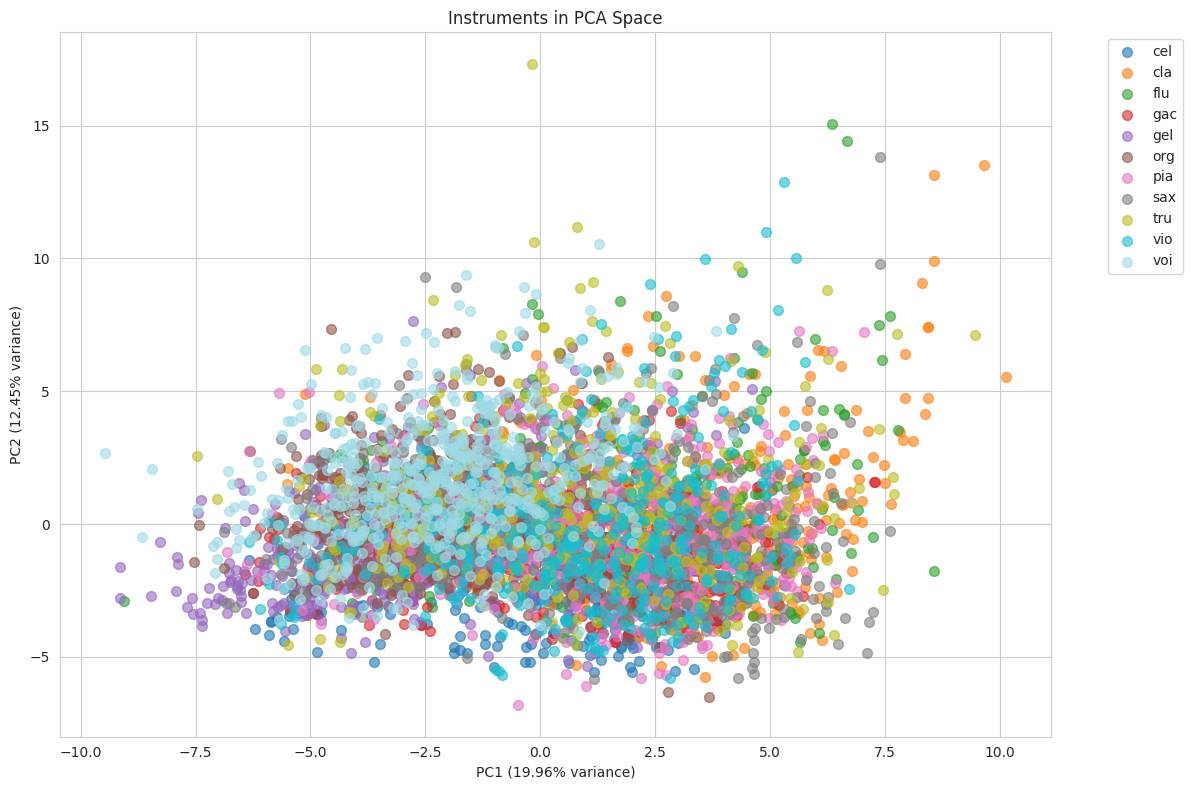

✓ PCA visualization saved


In [77]:
def visualize_pca(X_scaled, y, save_path):
    """Perform PCA and visualize first 2 components"""
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Cumulative variance: {np.sum(pca.explained_variance_ratio_):.2%}")

    # Plot
    plt.figure(figsize=(12, 8))
    unique_labels = np.unique(y)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    for idx, instrument in enumerate(unique_labels):
        mask = y == instrument
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   label=instrument, alpha=0.6, s=50, c=[colors[idx]])

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Instruments in PCA Space')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    print("✓ PCA visualization saved")

    return pca, X_pca

pca, X_train_pca = visualize_pca(X_train_scaled, y_train,
                                  f"{VIZ_PATH}/02_pca_visualization.png")

**K-Means Clustering Analysis**

Performing clustering analysis...
  k=2: Silhouette=0.1400
  k=3: Silhouette=0.1331
  k=4: Silhouette=0.0919
  k=5: Silhouette=0.0682
  k=6: Silhouette=0.0577
  k=7: Silhouette=0.0535
  k=8: Silhouette=0.0525
  k=9: Silhouette=0.0528
  k=10: Silhouette=0.0522
  k=11: Silhouette=0.0486
  k=12: Silhouette=0.0482

✓ Optimal k (by silhouette): 2


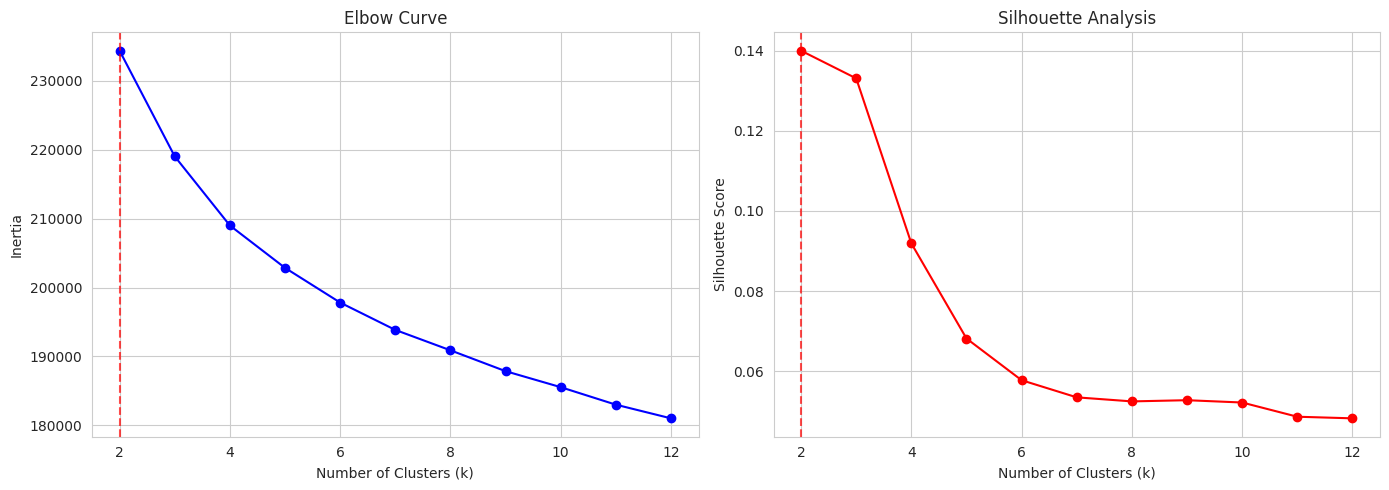

In [75]:
def perform_clustering_analysis(X_scaled, k_range=range(2, 13)):
    """Perform K-Means clustering with different k values"""
    inertias = []
    silhouette_scores = []

    print("Performing clustering analysis...")
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X_scaled, labels))
        print(f"  k={k}: Silhouette={silhouette_scores[-1]:.4f}")

    # Find optimal k
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\n✓ Optimal k (by silhouette): {optimal_k}")

    # Plot analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(k_range, inertias, 'bo-')
    axes[0].set_xlabel('Number of Clusters (k)')
    axes[0].set_ylabel('Inertia')
    axes[0].set_title('Elbow Curve')
    axes[0].grid(True)
    axes[0].axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7)

    axes[1].plot(k_range, silhouette_scores, 'ro-')
    axes[1].set_xlabel('Number of Clusters (k)')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('Silhouette Analysis')
    axes[1].grid(True)
    axes[1].axvline(x=optimal_k, color='r', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(f"{VIZ_PATH}/03_clustering_analysis.png", dpi=150, bbox_inches='tight')
    plt.show()

    return optimal_k, inertias, silhouette_scores

optimal_k, inertias, silhouette_scores = perform_clustering_analysis(X_train_scaled)


CLUSTER COMPOSITION ANALYSIS

Cluster 0 (2786 samples):
voi    545
org    497
gel    495
gac    223
tru    210
sax    206
pia    177
vio    159
flu    121
cel     80
cla     73

Cluster 1 (2578 samples):
pia    400
cla    331
vio    305
sax    295
gac    287
tru    251
flu    240
cel    230
gel    113
voi     77
org     49


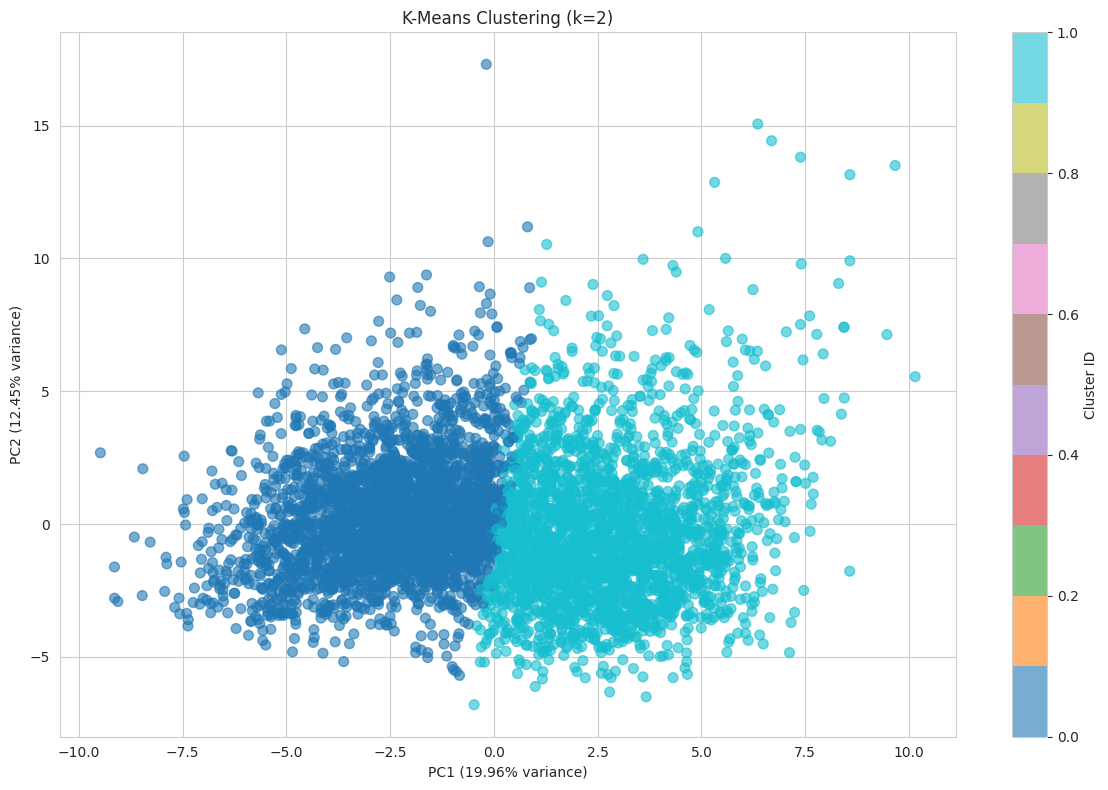


✓ Clustering analysis complete


In [76]:
# K Means with Optimal K
def cluster_and_analyze(X_scaled, y, optimal_k, X_pca, pca):
    """Perform K-Means clustering and analyze results"""
    # Train K-Means
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Analyze cluster composition
    print("\n" + "="*50)
    print("CLUSTER COMPOSITION ANALYSIS")
    print("="*50)

    cluster_composition = {}
    for cluster_id in range(optimal_k):
        mask = cluster_labels == cluster_id
        instruments_in_cluster = y[mask]
        counts = pd.Series(instruments_in_cluster).value_counts()
        cluster_composition[cluster_id] = counts

        print(f"\nCluster {cluster_id} ({len(instruments_in_cluster)} samples):")
        print(counts.to_string())

    # Visualize clusters on PCA
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1],
                         c=cluster_labels, cmap='tab10', alpha=0.6, s=50)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'K-Means Clustering (k={optimal_k})')
    plt.colorbar(scatter, label='Cluster ID')
    plt.tight_layout()
    plt.savefig(f"{VIZ_PATH}/04_kmeans_clusters.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("\n✓ Clustering analysis complete")

    return kmeans, cluster_labels, cluster_composition

kmeans, cluster_labels, cluster_composition = cluster_and_analyze(
    X_train_scaled, y_train, optimal_k, X_train_pca, pca)

# BaseLine Models

In [78]:
def train_baseline_models(X_train, X_test, y_train, y_test):
    """Train and evaluate baseline classification models"""
    models = {
        'Logistic Regression': LogisticRegression(max_iter=5000, multi_class='multinomial',
                                                   random_state=42),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'Naive Bayes': GaussianNB()
    }

    results = {}

    print("\n" + "="*50)
    print("TRAINING BASELINE MODELS")
    print("="*50)

    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        start_time = time.time()

        model.fit(X_train, y_train)
        training_time = time.time() - start_time

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Metrics
        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)

        results[model_name] = {
            'model': model,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'training_time': training_time,
            'y_pred_test': y_pred_test
        }

        print(f"  Train Accuracy: {train_acc:.4f}")
        print(f"  Test Accuracy: {test_acc:.4f}")
        print(f"  Training Time: {training_time:.2f}s")

        # Save model
        with open(f"{MODELS_PATH}/{model_name.replace(' ', '_')}.pkl", 'wb') as f:
            pickle.dump(model, f)

    print("\n✓ All baseline models trained and saved")
    return results

results = train_baseline_models(X_train_scaled, X_test_scaled, y_train, y_test)



TRAINING BASELINE MODELS

Training Logistic Regression...
  Train Accuracy: 0.5805
  Test Accuracy: 0.5474
  Training Time: 2.01s

Training Random Forest...
  Train Accuracy: 0.9989
  Test Accuracy: 0.6204
  Training Time: 4.77s

Training Naive Bayes...
  Train Accuracy: 0.4129
  Test Accuracy: 0.4094
  Training Time: 0.01s

✓ All baseline models trained and saved



BASELINE MODEL COMPARISON
              Model  Train_Accuracy  Test_Accuracy  Training_Time_s
Logistic Regression        0.580537       0.547353         2.005385
      Random Forest        0.998881       0.620433         4.766489
        Naive Bayes        0.412938       0.409396         0.011900


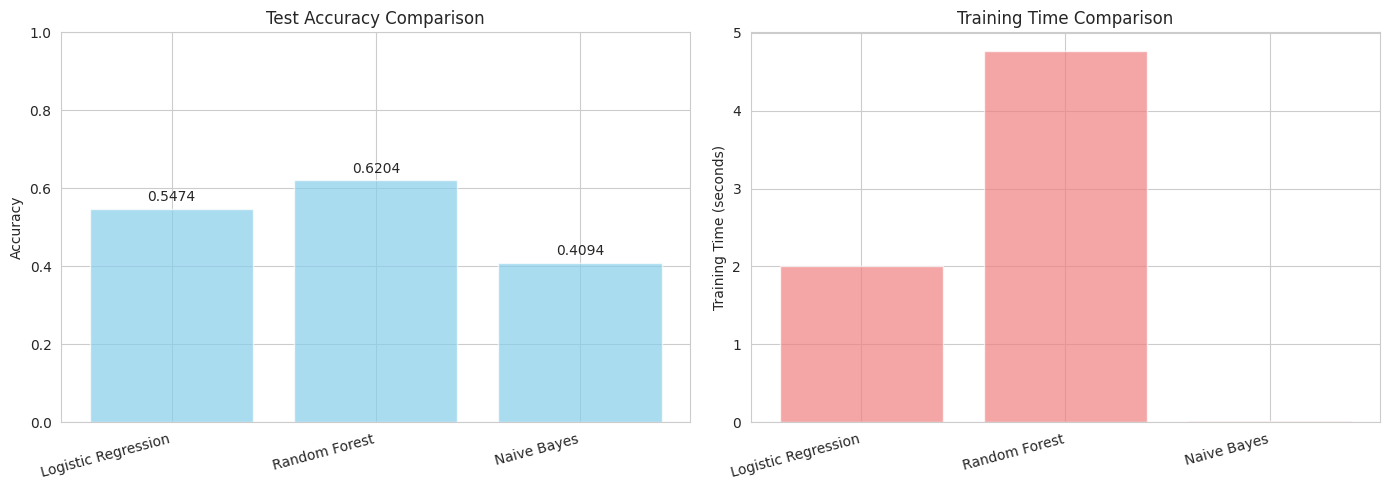


✓ Baseline results saved


In [79]:
def compare_baseline_results(results, save_path):
    """Compare and visualize baseline model results"""
    # Create results dataframe
    results_df = pd.DataFrame({
        'Model': results.keys(),
        'Train_Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
        'Test_Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
        'Training_Time_s': [results[m]['training_time'] for m in results.keys()]
    })

    print("\n" + "="*50)
    print("BASELINE MODEL COMPARISON")
    print("="*50)
    print(results_df.to_string(index=False))

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy comparison
    x_pos = np.arange(len(results_df))
    axes[0].bar(x_pos, results_df['Test_Accuracy'], alpha=0.7, color='skyblue')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Test Accuracy Comparison')
    axes[0].set_ylim([0, 1.0])

    for i, v in enumerate(results_df['Test_Accuracy']):
        axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=10)

    # Training time comparison
    axes[1].bar(x_pos, results_df['Training_Time_s'], alpha=0.7, color='lightcoral')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
    axes[1].set_ylabel('Training Time (seconds)')
    axes[1].set_title('Training Time Comparison')

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    # Save results
    results_df.to_csv(f"{RESULTS_PATH}/baseline_results.csv", index=False)
    print("\n✓ Baseline results saved")

    return results_df

results_df = compare_baseline_results(results, f"{VIZ_PATH}/05_baseline_comparison.png")


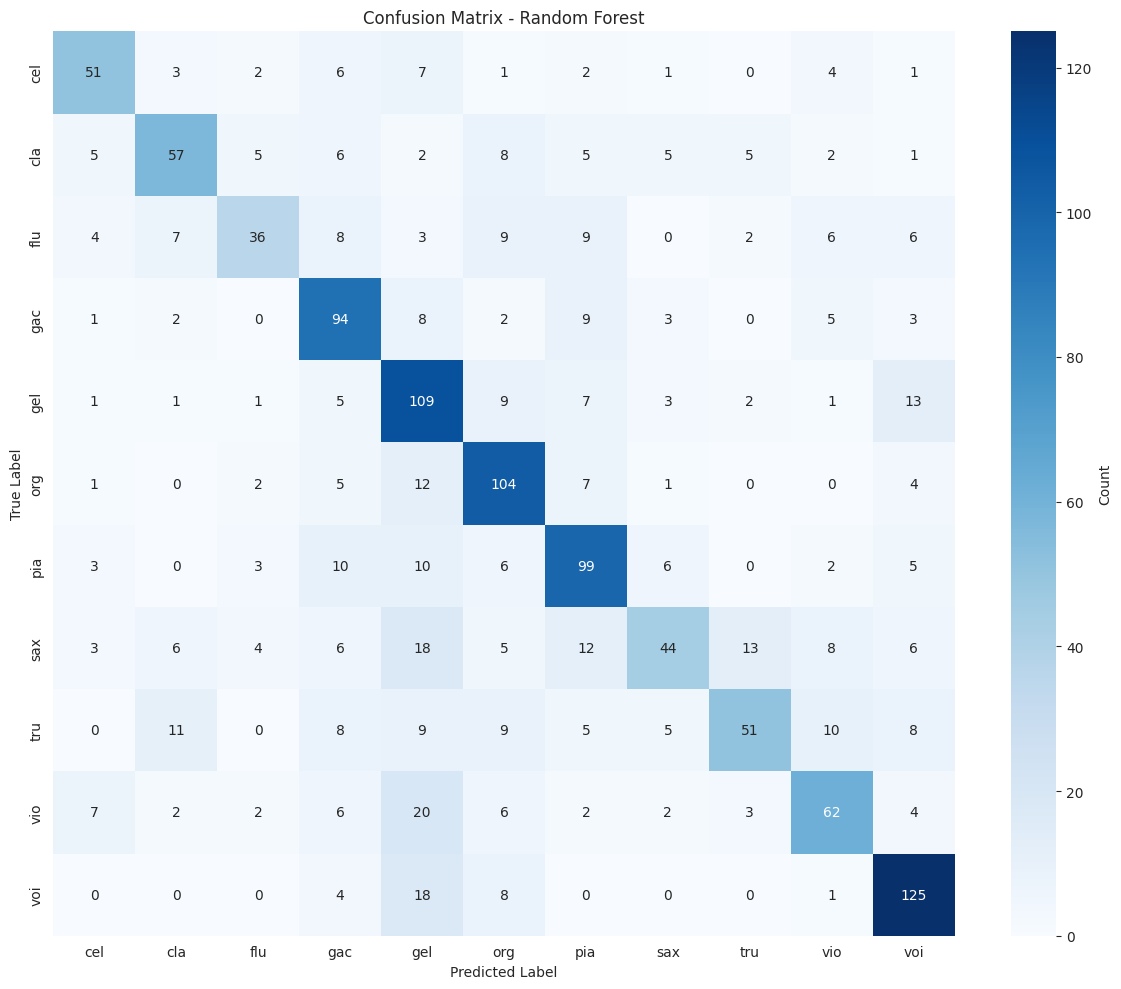


COMMONLY CONFUSED INSTRUMENT PAIRS
     Pair  Total_Confusions  i_to_j  j_to_i
gel ↔ voi                31      13      18
gel ↔ sax                21       3      18
gel ↔ vio                21       1      20
gel ↔ org                21       9      12
gac ↔ pia                19       9      10
pia ↔ sax                18       6      12
sax ↔ tru                18      13       5
gel ↔ pia                17       7      10
cla ↔ tru                16       5      11
org ↔ pia                13       7       6
gac ↔ gel                13       8       5
tru ↔ vio                13      10       3
org ↔ voi                12       4       8
cla ↔ flu                12       5       7
flu ↔ pia                12       9       3

✓ Confusion analysis saved


In [80]:
def analyze_confusion_matrix(y_true, y_pred, model_name, save_path):
    """Create and analyze confusion matrix"""
    # Get confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    unique_labels = np.unique(y_true)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_labels,
                yticklabels=unique_labels,
                cbar_kws={'label': 'Count'})
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    # Identify commonly confused pairs
    print("\n" + "="*50)
    print("COMMONLY CONFUSED INSTRUMENT PAIRS")
    print("="*50)

    confusion_pairs = []
    for i in range(len(unique_labels)):
        for j in range(i+1, len(unique_labels)):
            total_confusion = cm[i][j] + cm[j][i]
            if total_confusion > 0:
                confusion_pairs.append({
                    'Pair': f"{unique_labels[i]} ↔ {unique_labels[j]}",
                    'Total_Confusions': total_confusion,
                    'i_to_j': cm[i][j],
                    'j_to_i': cm[j][i]
                })

    confusion_df = pd.DataFrame(confusion_pairs).sort_values(
        'Total_Confusions', ascending=False)
    print(confusion_df.head(15).to_string(index=False))

    confusion_df.to_csv(f"{RESULTS_PATH}/confusion_pairs.csv", index=False)
    print("\n✓ Confusion analysis saved")

    return cm, confusion_df

# Analyze best performing model (Random Forest)
best_model_name = results_df.loc[results_df['Test_Accuracy'].idxmax(), 'Model']
best_predictions = results[best_model_name]['y_pred_test']

cm, confusion_df = analyze_confusion_matrix(
    y_test, best_predictions, best_model_name,
    f"{VIZ_PATH}/06_confusion_matrix_best.png")

# Hierarchial Structure Creation

In [81]:
def create_hierarchical_structure(cluster_composition, optimal_k):
    """Create hierarchical instrument groupings based on clusters"""
    # Create instrument-to-cluster mapping
    instrument_to_cluster = {}
    for cluster_id, composition in cluster_composition.items():
        for instrument in composition.index:
            instrument_to_cluster[instrument] = cluster_id

    print("\n" + "="*50)
    print("HIERARCHICAL STRUCTURE")
    print("="*50)
    print("\nInstrument to Cluster Mapping:")
    for instrument, cluster in sorted(instrument_to_cluster.items()):
        print(f"  {instrument}: Cluster {cluster}")

    # Create cluster groups
    cluster_groups = {}
    for k in range(optimal_k):
        cluster_groups[k] = [inst for inst, clust in instrument_to_cluster.items()
                            if clust == k]

    print("\nCluster Groups:")
    for k, instruments_list in cluster_groups.items():
        print(f"  Cluster {k}: {instruments_list}")

    # Save hierarchy
    hierarchy_data = {
        'instrument_to_cluster': instrument_to_cluster,
        'cluster_groups': {str(k): v for k, v in cluster_groups.items()},
        'optimal_k': optimal_k
    }

    with open(f"{PROJECT_PATH}/hierarchy.json", 'w') as f:
        json.dump(hierarchy_data, f, indent=2)

    print("\n✓ Hierarchical structure saved")
    return instrument_to_cluster, cluster_groups

instrument_to_cluster, cluster_groups = create_hierarchical_structure(
    cluster_composition, optimal_k)



HIERARCHICAL STRUCTURE

Instrument to Cluster Mapping:
  cel: Cluster 1
  cla: Cluster 1
  flu: Cluster 1
  gac: Cluster 1
  gel: Cluster 1
  org: Cluster 1
  pia: Cluster 1
  sax: Cluster 1
  tru: Cluster 1
  vio: Cluster 1
  voi: Cluster 1

Cluster Groups:
  Cluster 0: []
  Cluster 1: ['voi', 'org', 'gel', 'gac', 'tru', 'sax', 'pia', 'vio', 'flu', 'cel', 'cla']

✓ Hierarchical structure saved


In [82]:
print("\n" + "="*70)
print("PROJECT SUMMARY")
print("="*70)
print(f"Dataset: {len(instruments)} instruments, {len(X_full)} samples")
print(f"Features: {X_full.shape[1]} audio features extracted")
print(f"Train/Test Split: {len(X_train)}/{len(X_test)} samples")
print(f"Optimal Clusters: {optimal_k}")
print(f"\nBest Model: {best_model_name}")
print(f"Best Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print("\n✓ All analyses complete!")
print(f"✓ Results saved to: {PROJECT_PATH}")
print("="*70)


PROJECT SUMMARY
Dataset: 11 instruments, 6705 samples
Features: 51 audio features extracted
Train/Test Split: 5364/1341 samples
Optimal Clusters: 2

Best Model: Random Forest
Best Test Accuracy: 0.6204

✓ All analyses complete!
✓ Results saved to: /content/drive/MyDrive/IRMAS_Project
